In [110]:
import os, sys
sys.path.append( os.path.join(os.environ['CODE'], 'analysis_tools') )
from Tools.Operators import EyeSignalOperator
import pandas as pd
%pylab
import seaborn as sns
%matplotlib inline
reload(EyeSignalOperator)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


<module 'Tools.Operators.EyeSignalOperator' from '/Users/janwillem/Documents/Donnerlabcode/analysis_tools/Tools/Operators/EyeSignalOperator.py'>

Let's load some raw pupil data.

EyeSignalOperator expects an inputObject that is a dictionary with keys "timepoints", "gazeXY", "pupil" and the corresponding timeseries as values. Additionally, we can (but don't have to) pass a dictionary called "eyelink_blink_data" and "eyelink_sac_data". 

In [111]:
eye_dict = pd.read_csv('data/eye_dict.csv')
blink_dict = pd.read_csv('data/blink_dict.csv')
sac_dict = pd.read_csv('data/sac_dict.csv')
sample_rate = 1000
eso = EyeSignalOperator.EyeSignalOperator(
    inputObject=eye_dict,
    eyelink_blink_data=blink_dict,
    eyelink_sac_data=sac_dict,
    sample_rate=sample_rate)

Let's plot the raw pupil timeseries:

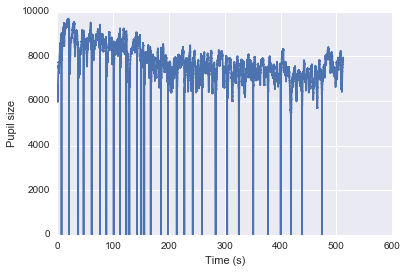

In [112]:
start_time = eso.timepoints[0]
x = (eso.timepoints - start_time) / sample_rate
plot(x, eso.raw_pupil)
xlabel('Time (s)')
ylabel('Pupil size')

The periods where the timeseries drop to 0 correspond to blinks. Let's double check that intuition with the blink timestamps we obtained from EyeLink:

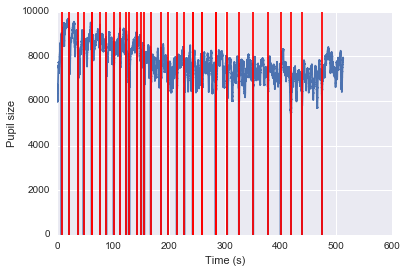

In [113]:
plot(x, eso.raw_pupil)
for bl in eso.blink_ends_EL:
    blink = (bl) / sample_rate
    axvline(blink, color='r')
xlabel('Time (s)')
ylabel('Pupil size')

Let's linearly interpolate these blinks, and string blinks together if they occur within 250ms of each other.

15-11-26_17-20-42 - INFO - EyeSignalOperator - Interpolating blinks using interpolate_blinks


INFO:EyeSignalOperator:Interpolating blinks using interpolate_blinks


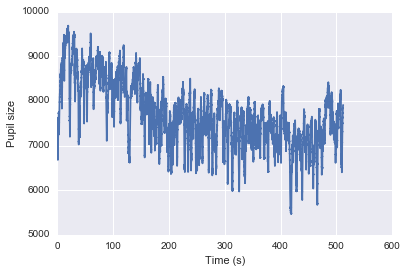

In [114]:
eso.interpolate_blinks(method='linear', coalesce_period=500)
plot(x, eso.interpolated_pupil)
xlabel('Time (s)')
ylabel('Pupil size')

To see what happened, let's zoom in on one interpolated blink:

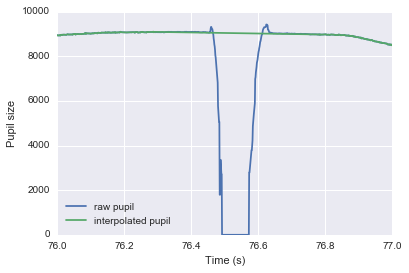

In [129]:
plot(x, eso.raw_pupil, label='raw pupil')
plot(x, eso.interpolated_pupil, label='interpolated pupil')
xlim( (eso.blink_starts[5] - 100) / sample_rate, (eso.blink_ends[5] + 500) / sample_rate )
xlabel('Time (s)')
ylabel('Pupil size')
legend(loc=3)

Let's filter blink interpolated pupil timeseries now. We'll construct a low pass (<10Hz), and a band-pass (0.01-10Hz) signal. And again, let's plot the results.

15-11-26_17-24-07 - INFO - EyeSignalOperator - Band-pass filtering of pupil signals, hp = 0.010, lp = 10.000


INFO:EyeSignalOperator:Band-pass filtering of pupil signals, hp = 0.010, lp = 10.000


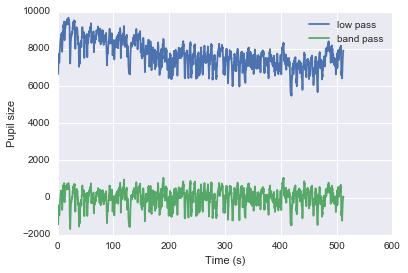

In [130]:
eso.filter_pupil(hp=0.01, lp=10.0)
plot(x, eso.lp_filt_pupil, label='low pass')
plot(x, eso.bp_filt_pupil, label='band pass')
xlabel('Time (s)')
ylabel('Pupil size')
legend()

The band-pass filtered signal we can use now to estimate pupil responses to blinks and saccades. You can think of these of simple event related averages. However, to account for temporally adjacent event, and hence overlapping responses (due to slow pupil IRF), here we will rely on deconvolution. 

In [131]:
eso.regress_blinks()

15-11-26_17-24-08 - INFO - DeconvolutionOperator - upsampled from (5124,) to (5124,) according to ratio 1.0


INFO:DeconvolutionOperator:upsampled from (5124,) to (5124,) according to ratio 1.0


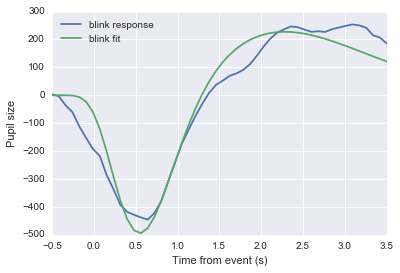

In [132]:
xx = np.linspace(-0.5, 3.5, len(eso.blink_response))
plot(xx, eso.blink_response, label='blink response')
plot(xx, eso.blink_fit, label='blink fit')
xlabel('Time from event (s)')
ylabel('Pupil size')
legend(loc=2)

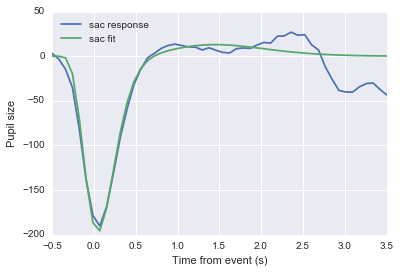

In [133]:
xx = np.linspace(-0.5, 3.5, len(eso.blink_response))
plot(xx, eso.sac_response, label='sac response')
plot(xx, eso.sac_fit, label='sac fit')
xlabel('Time from event (s)')
ylabel('Pupil size')
legend(loc=2)

Now, with a GLM let's resgress these pupil responses to blinks and saccades from the blink interpolated and band-passed filtered pupil timeseries. 

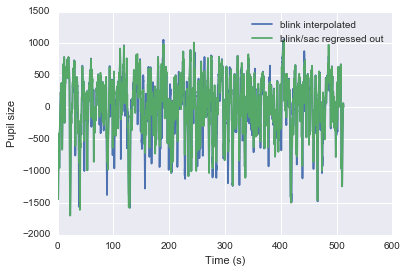

In [124]:
plot(x, eso.bp_filt_pupil, label='blink interpolated')
plot(x, eso.bp_filt_pupil_clean-eso.baseline_filt_pupil.mean(), label='blink/sac regressed out')
xlabel('Time (s)')
ylabel('Pupil size')
legend()

Finally, let's add back the slow drift, which is meaningfull part of the signal!

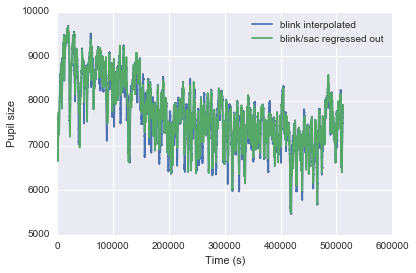

In [125]:
plot(eso.interpolated_pupil, label='blink interpolated')
plot(eso.lp_filt_pupil_clean, label='blink/sac regressed out')
xlabel('Time (s)')
ylabel('Pupil size')
legend()